In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Dec 19 13:46:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   38C    P8    24W / 250W |   5572MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   42C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mjp_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mjp_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mjp_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mjp_07July2020 import All_CNN6Layer_E as ModelE
from model.models_mjp_07July2020 import All_CNN6Layer_F as ModelF
from model.models_mjp_07July2020 import All_CNN6Layer_G as ModelG
from model.models_mjp_07July2020 import All_CNN6Layer_H as ModelH
from model.models_mjp_07July2020 import All_CNN6Layer_I as ModelI
from model.models_mjp_07July2020 import All_CNN6Layer_J as ModelJ
from model.models_mjp_07July2020 import All_CNN6Layer_K as ModelK
from model.models_mjp_07July2020 import All_CNN6Layer_L as ModelL
from model.models_mjp_07July2020 import All_CNN6Layer_M as ModelM
from model.models_mjp_07July2020 import All_CNN6Layer_N as ModelN

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 40, 5e-5, 1620)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 12.61 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.82 s
Constructing 160000 event dataset took 3.893 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.087 s
Constructing 9984 event dataset took 0.1267 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelA()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/8d2a957ee46d4706a7a9ce6db1e46b20/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_A(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


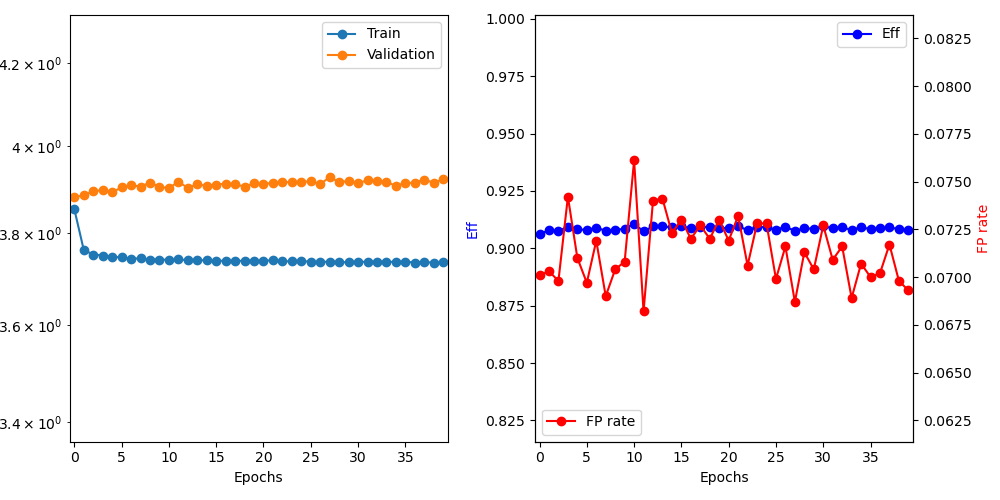

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  All_CNN6Layer_A(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 1620
batch_size 128
epochs 40
lr 5e-05
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1620: train=3.85389, val=3.88066, took 53.848 s
  Validation Found 49399 of 54504, added 700 (eff 90.63%) (0.0701 FP/event)
Result epoch:  1620
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1621: train=3.76236, val=3.88573, took 54.107 s
  Validation Found 49478 of 54504, added 702 (eff 90.78%) (0.0703 FP/event)
Result epoch:  1621
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1622: train=3.75242, val=3.89475, took 53.906 s
  Validation Found 49458 of 54504, added 697 (eff 90.74%) (0.0698 FP/event)
Result epoch:  1622
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1623: train=3.75025, val=3.89738, took 53.888 s
  Validation Found 49571 of 54504, added 741 (eff 90.95%) (0.0742 FP/event)
Result epoch:  1623
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1624: train=3.74734, val=3.89192, took 57.674 s
  Validation Found 49501 of 54504, added 709 (eff 90.82%) (0.071 FP/event)
Result epoch:  1624
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1625: train=3.74605, val=3.90396, took 59.984 s
  Validation Found 49493 of 54504, added 696 (eff 90.81%) (0.0697 FP/event)
Result epoch:  1625
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1626: train=3.74311, val=3.90848, took 59.461 s
  Validation Found 49538 of 54504, added 718 (eff 90.89%) (0.0719 FP/event)
Result epoch:  1626
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1627: train=3.74406, val=3.90559, took 60.149 s
  Validation Found 49474 of 54504, added 689 (eff 90.77%) (0.069 FP/event)
Result epoch:  1627
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1628: train=3.7413, val=3.91456, took 59.796 s
  Validation Found 49488 of 54504, added 703 (eff 90.80%) (0.0704 FP/event)
Result epoch:  1628
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1629: train=3.74128, val=3.90493, took 60.593 s
  Validation Found 49520 of 54504, added 707 (eff 90.86%) (0.0708 FP/event)
Result epoch:  1629
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1630: train=3.74087, val=3.90188, took 60.389 s
  Validation Found 49633 of 54504, added 760 (eff 91.06%) (0.0761 FP/event)
Result epoch:  1630
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1631: train=3.74175, val=3.91657, took 60.063 s
  Validation Found 49457 of 54504, added 681 (eff 90.74%) (0.0682 FP/event)
Result epoch:  1631
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1632: train=3.73985, val=3.90239, took 60.796 s
  Validation Found 49572 of 54504, added 739 (eff 90.95%) (0.074 FP/event)
Result epoch:  1632
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1633: train=3.73979, val=3.91053, took 60.302 s
  Validation Found 49578 of 54504, added 740 (eff 90.96%) (0.0741 FP/event)
Result epoch:  1633
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1634: train=3.73976, val=3.90727, took 60.368 s
  Validation Found 49549 of 54504, added 722 (eff 90.91%) (0.0723 FP/event)
Result epoch:  1634
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1635: train=3.73808, val=3.90991, took 60.641 s
  Validation Found 49576 of 54504, added 729 (eff 90.96%) (0.073 FP/event)
Result epoch:  1635
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1636: train=3.73908, val=3.91243, took 60.342 s
  Validation Found 49531 of 54504, added 719 (eff 90.88%) (0.072 FP/event)
Result epoch:  1636
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1637: train=3.73839, val=3.91088, took 60.527 s
  Validation Found 49562 of 54504, added 726 (eff 90.93%) (0.0727 FP/event)
Result epoch:  1637
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1638: train=3.73856, val=3.90551, took 60.699 s
  Validation Found 49558 of 54504, added 719 (eff 90.93%) (0.072 FP/event)
Result epoch:  1638
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1639: train=3.73859, val=3.91277, took 60.025 s
  Validation Found 49545 of 54504, added 729 (eff 90.90%) (0.073 FP/event)
Result epoch:  1639
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1640: train=3.73839, val=3.91095, took 60.708 s
  Validation Found 49530 of 54504, added 718 (eff 90.87%) (0.0719 FP/event)
Result epoch:  1640
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1641: train=3.73988, val=3.91452, took 60.877 s
  Validation Found 49588 of 54504, added 731 (eff 90.98%) (0.0732 FP/event)
Result epoch:  1641
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1642: train=3.73737, val=3.91598, took 60.435 s
  Validation Found 49478 of 54504, added 705 (eff 90.78%) (0.0706 FP/event)
Result epoch:  1642
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1643: train=3.7376, val=3.91543, took 60.171 s
  Validation Found 49569 of 54504, added 727 (eff 90.95%) (0.0728 FP/event)
Result epoch:  1643
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1644: train=3.73746, val=3.91546, took 60.162 s
  Validation Found 49553 of 54504, added 727 (eff 90.92%) (0.0728 FP/event)
Result epoch:  1644
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1645: train=3.73699, val=3.91832, took 61.072 s
  Validation Found 49497 of 54504, added 698 (eff 90.81%) (0.0699 FP/event)
Result epoch:  1645
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1646: train=3.73593, val=3.91054, took 60.425 s
  Validation Found 49562 of 54504, added 715 (eff 90.93%) (0.0716 FP/event)
Result epoch:  1646
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1647: train=3.73677, val=3.92769, took 60.004 s
  Validation Found 49471 of 54504, added 686 (eff 90.77%) (0.0687 FP/event)
Result epoch:  1647
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1648: train=3.73581, val=3.91525, took 60.54 s
  Validation Found 49526 of 54504, added 712 (eff 90.87%) (0.0713 FP/event)
Result epoch:  1648
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1649: train=3.73512, val=3.91864, took 60.43 s
  Validation Found 49521 of 54504, added 703 (eff 90.86%) (0.0704 FP/event)
Result epoch:  1649
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1650: train=3.7362, val=3.91362, took 59.982 s
  Validation Found 49573 of 54504, added 726 (eff 90.95%) (0.0727 FP/event)
Result epoch:  1650
Average Eff:  0.9095295758109496
Average FP Rate:  0.07270906359539309


Epoch 1651: train=3.73647, val=3.91978, took 60.047 s
  Validation Found 49532 of 54504, added 708 (eff 90.88%) (0.0709 FP/event)
Result epoch:  1651
Average Eff:  1.818306913254073
Average FP Rate:  0.14361542313470205


Epoch 1652: train=3.73606, val=3.91841, took 60.621 s
  Validation Found 49553 of 54504, added 715 (eff 90.92%) (0.0716 FP/event)
Result epoch:  1652
Average Eff:  2.7274695435197414
Average FP Rate:  0.21522283425137706


Epoch 1653: train=3.73686, val=3.91524, took 60.144 s
  Validation Found 49487 of 54504, added 688 (eff 90.80%) (0.0689 FP/event)
Result epoch:  1653
Average Eff:  3.6354212534859824
Average FP Rate:  0.28412618928392586


Epoch 1654: train=3.73578, val=3.90792, took 60.201 s
  Validation Found 49558 of 54504, added 706 (eff 90.93%) (0.0707 FP/event)
Result epoch:  1654
Average Eff:  4.544675620137971
Average FP Rate:  0.3548322483725588


Epoch 1655: train=3.73666, val=3.91321, took 60.83 s
  Validation Found 49505 of 54504, added 699 (eff 90.83%) (0.07 FP/event)
Result epoch:  1655
Average Eff:  5.452957581094965
Average FP Rate:  0.4248372558838257


Epoch 1656: train=3.73476, val=3.91465, took 60.693 s
  Validation Found 49526 of 54504, added 701 (eff 90.87%) (0.0702 FP/event)
Result epoch:  1656
Average Eff:  6.361624834874504
Average FP Rate:  0.4950425638457686


Epoch 1657: train=3.73588, val=3.92134, took 60.252 s
  Validation Found 49549 of 54504, added 716 (eff 90.91%) (0.0717 FP/event)
Result epoch:  1657
Average Eff:  7.270714076031116
Average FP Rate:  0.5667501251877817


Epoch 1658: train=3.7344, val=3.9144, took 60.573 s
  Validation Found 49511 of 54504, added 697 (eff 90.84%) (0.0698 FP/event)
Result epoch:  1658
Average Eff:  8.179106120651694
Average FP Rate:  0.6365548322483725


Epoch 1659: train=3.73489, val=3.92192, took 60.845 s
  Validation Found 49485 of 54504, added 692 (eff 90.79%) (0.0693 FP/event)
Result epoch:  1659
Averaging...

Average Eff:  0.9087021136063408
Average FP Rate:  0.07058587881822734



<IPython.core.display.Javascript object>


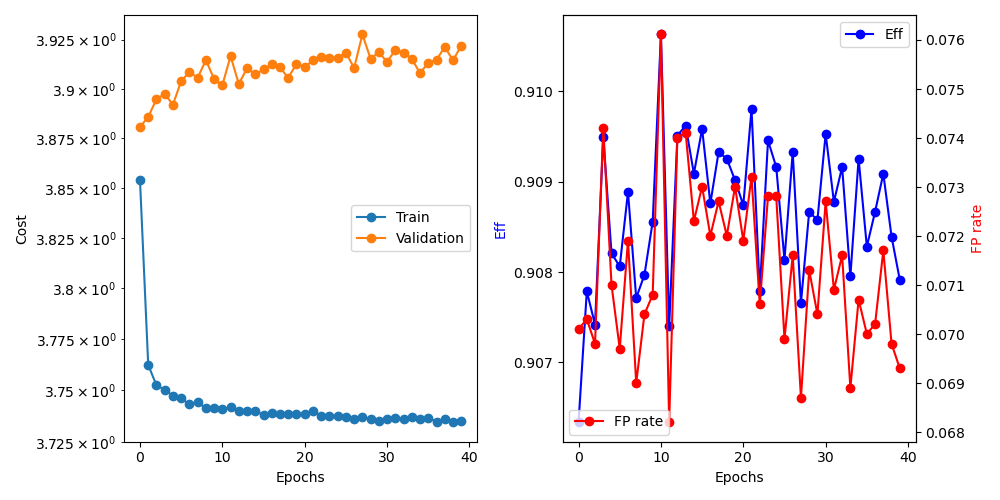

In [12]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'ACNN A Avg.'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        # filter first cost epoch
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
        
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')
        mlflow.set_tag('Asymmetry', '0.0')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()